This notebook is doing a monte carlo simulation of bushfire risk using the vegetation index

In [1]:
from path import Path
import arrow
import json
import pytz
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
import re, os, collections, itertools, uuid, logging
import tempfile

import zipfile
import urllib

import ee
import pyproj
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import shapely

from scipy.misc import imread, imsave
%matplotlib inline
# %precision 4
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6) # bigger plots
sns.set_palette("Set2", 10)

In [2]:
helper_dir = str(Path('.').abspath())
if helper_dir not in os.sys.path:
    os.sys.path.append(helper_dir)
    
from leak_helpers.earth_engine import display_ee, get_boundary, tifs2np, bands_s2, download_image, bands_s1, bands_l7, bands_l8
from leak_helpers.visualization import imshow_bands

# Params

In [3]:
# init
crs_grid = 3857 # projected wgs84
# if the satelite's note included in the metadata jsut add it

resolution_min=30 # 30m min
distance=1700
pixel_length=int(distance/resolution_min)

# black saturday
time = arrow.get('2009-02-06')
point = shapely.geometry.Point(145.3408333333,-37.5327777778) # Kingslake, where some black sat fire started
# point = shapely.geometry.Point(116.7413748,-31.8739154) # york, WA, AY

# time = arrow.get('2015-02-08')
# point = shapely.geometry.Point(115.833333,-31.933333) # perth


point = shapely.geometry.Point(116.0258274,-31.767647)
name = 'bridagadoon'

pixels=2.0*distance/resolution_min
print('pixels',pixels,pixels)

pixels 113.33333333333333 113.33333333333333


In [4]:
# uid = uuid.uuid4().hex
# temp_dir = cache_dir = Path(tempfile.mkdtemp())

In [5]:
ts = time.utcnow().format('YYYYMMDD-HHmmss')
folder_name = '{name:}_{time:}'.format(name=name,time=ts)
# image_folder = Path('../images/').joinpath(folder_name)
# image_folder.makedirs_p()

# download image

In [6]:
import ee
ee.Initialize() # should give no errors, if so follow instructions

# get boundary to crop/search image with
coords = np.array(point.xy)[:, 0].tolist()
geom = ee.Geometry.Point(coords)
bound = ee.Geometry.buffer(geometry=geom, distance=distance)
boundary = bound.bounds()

## vegetation index

In [7]:
satellite='LANDSAT/LC8_L1T_ANNUAL_EVI'
bands=bands_l8

In [8]:
# search for image
sentinel2_before = ee.ImageCollection(satellite)\
    .filterBounds(boundary)\
    .sort('system:time_start', opt_ascending=False) # first will be latest
assert sentinel2_before.size().getInfo()>0,'oh no, no image results'
image = ee.Image(sentinel2_before.first()).clip(boundary)
info = image.getInfo()
image

In [9]:
path,files=download_image(
    image, 
    scale=resolution_min, 
    crs=crs_grid, 
#     name=arrow.now().format('YYYYMMDD-HH-mm-ss'),
    report=True,
    cache_dir=Path('../images'),
    name=folder_name
)
path, files

download?docid=d707d50a168cb5a7211254c48: 49.2KB [00:02, 17.7KB/s]


(Path('../images/bridagadoon_20170429-035319_3857_30'),
 ['2017.EVI.tfw', '2017.EVI.tif'])

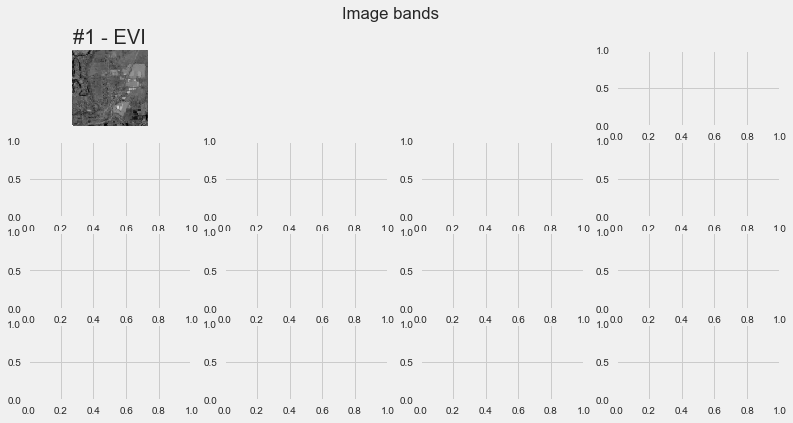

In [10]:
# view
X = tifs2np(path, files, bands=['EVI'])
for i in range(X.shape[0]):
    x=X[i]
    X[i]=(x-x.min())/(x.max()-x.min())
imshow_bands(X, labels=['EVI'])

In [11]:
X.min(),X.max(),X[0]

(0.0, 1.0, array([[ 0.66792721,  0.59451181,  0.57091498, ...,  0.71972948,
          0.67379487,  0.63638115],
        [ 0.68652916,  0.65028214,  0.62409121, ...,  0.72823453,
          0.69836932,  0.66261804],
        [ 0.68652916,  0.65028214,  0.62409121, ...,  0.72823453,
          0.69836932,  0.66261804],
        ..., 
        [ 0.74347419,  0.74212247,  0.74279177, ...,  0.75549227,
          0.73361009,  0.73411673],
        [ 0.74347419,  0.74212247,  0.74279177, ...,  0.75549227,
          0.73361009,  0.73411673],
        [ 0.        ,  0.73959708,  0.74278408, ...,  0.70226532,
          0.67600071,  0.72799039]], dtype=float32))

# download normal bands

In [12]:
satellite='LANDSAT/LC8_L1T_TOA'
bands=bands_l8

In [13]:
# search for image
sentinel2_before = ee.ImageCollection(satellite)\
    .filterBounds(boundary)\
    .sort('system:time_start', opt_ascending=False) # first will be latest
assert sentinel2_before.size().getInfo()>0,'oh no, no image results'
image = ee.Image(sentinel2_before.first()).clip(boundary)
info = image.getInfo()
image

In [14]:
path,files=download_image(
    image, 
    scale=resolution_min, 
    crs=crs_grid, 
#     name=arrow.now().format('YYYYMMDD-HH-mm-ss'),
    report=True,
    cache_dir=Path('../images'),
    name=folder_name
)
path,files

download?docid=caa686dc18239846f4602ef4d: 393KB [00:03, 126KB/s]  


(Path('../images/bridagadoon_20170429-035319_3857_30'),
 ['2017.EVI.tfw',
  '2017.EVI.tif',
  'LC81120822017114LGN00.B1.tfw',
  'LC81120822017114LGN00.B1.tif',
  'LC81120822017114LGN00.B10.tfw',
  'LC81120822017114LGN00.B10.tif',
  'LC81120822017114LGN00.B11.tfw',
  'LC81120822017114LGN00.B11.tif',
  'LC81120822017114LGN00.B2.tfw',
  'LC81120822017114LGN00.B2.tif',
  'LC81120822017114LGN00.B3.tfw',
  'LC81120822017114LGN00.B3.tif',
  'LC81120822017114LGN00.B4.tfw',
  'LC81120822017114LGN00.B4.tif',
  'LC81120822017114LGN00.B5.tfw',
  'LC81120822017114LGN00.B5.tif',
  'LC81120822017114LGN00.B6.tfw',
  'LC81120822017114LGN00.B6.tif',
  'LC81120822017114LGN00.B7.tfw',
  'LC81120822017114LGN00.B7.tif',
  'LC81120822017114LGN00.B8.tfw',
  'LC81120822017114LGN00.B8.tif',
  'LC81120822017114LGN00.B9.tfw',
  'LC81120822017114LGN00.B9.tif',
  'LC81120822017114LGN00.BQA.tfw',
  'LC81120822017114LGN00.BQA.tif'])

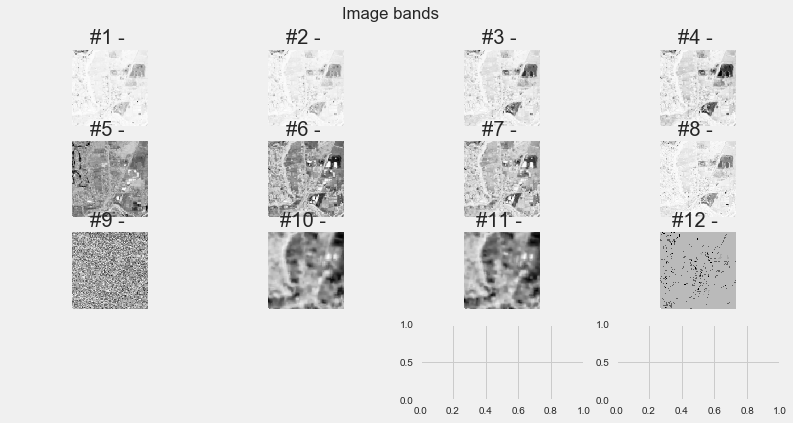

In [15]:
# view
X = tifs2np(path, files, bands=bands_l8)
imshow_bands(X, labels=None)

In [16]:
# convert to png and normalise to 0-1
for file in path.glob('*.tif'):
    if not file.endswith('tif'): continue
    impath = file
    impath_out = impath.replace('.tif','.png')
#     X = plt.imread(impath)
    X = imread(impath)
    print(X.min(),X.max(),X.shape)
    # normalise it
    X=(X-X.min())/(X.max()-X.min()+1e-7)
    print(X.min(),X.max())
    plt.imsave(impath_out,X,format='png')
    print(impath_out)


-1.0 1.0 (135, 134)
0.0 1.0
../images/bridagadoon_20170429-035319_3857_30/2017.EVI.png
-inf 0.304139 (135, 134)
nan nan
../images/bridagadoon_20170429-035319_3857_30/LC81120822017114LGN00.B1.png
-inf 300.193 (135, 134)
nan nan
../images/bridagadoon_20170429-035319_3857_30/LC81120822017114LGN00.B10.png
-inf 298.52 (135, 134)
nan nan
../images/bridagadoon_20170429-035319_3857_30/LC81120822017114LGN00.B11.png
-inf 0.328687 (135, 134)
nan nan
../images/bridagadoon_20170429-035319_3857_30/LC81120822017114LGN00.B2.png
-inf 0.33967 (135, 134)
nan nan
../images/bridagadoon_20170429-035319_3857_30/LC81120822017114LGN00.B3.png
-inf 0.379451 (135, 134)
nan nan
../images/bridagadoon_20170429-035319_3857_30/LC81120822017114LGN00.B4.png
-inf 0.55544 (135, 134)
nan nan
../images/bridagadoon_20170429-035319_3857_30/LC81120822017114LGN00.B5.png
-inf 0.537419 (135, 134)
nan nan
../images/bridagadoon_20170429-035319_3857_30/LC81120822017114LGN00.B6.png
-inf 0.443441 (135, 134)
nan nan
../images/bridagado

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in subtract
  # Remove the CWD from sys.path while we load stuff.
/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/matplotlib/colors.py:821: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/numpy/ma/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


(3, 135, 134)


/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


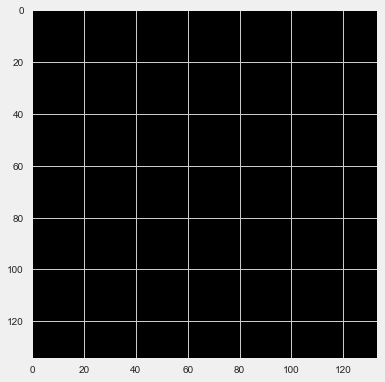

In [17]:
# view rgb
X = tifs2np(path, files, bands=bands_l8[1:4])
print(X.shape)
X=(X-X.min())/(X.max()-X.min())
X=np.transpose(X,(1,2,0))
X=X[:,:,::-1] # BGR to RGB
plt.imshow(X)
plt.imsave(path.joinpath('visual.png'),X)

# height

In [18]:
# download elevation


In [19]:
# search for image
image = ee.Image('USGS/SRTMGL1_003').clip(boundary)
info = image.getInfo()
image

In [20]:
path,files=download_image(
    image, 
    scale=resolution_min, 
    crs=crs_grid, 
#     name=arrow.now().format('YYYYMMDD-HH-mm-ss'),
    report=True,
    cache_dir=Path('../images'),
    name=folder_name
)
path,files

download?docid=8a62686259ca27856a3194e7a: 16.4KB [00:03, 5.43KB/s]


(Path('../images/bridagadoon_20170429-035319_3857_30'),
 ['LC81120822017114LGN00.B4.tfw',
  '2017.EVI.png',
  '2017.EVI.tfw',
  '2017.EVI.tif',
  'LC81120822017114LGN00.B1.png',
  'LC81120822017114LGN00.B1.tfw',
  'LC81120822017114LGN00.B1.tif',
  'LC81120822017114LGN00.B10.png',
  'LC81120822017114LGN00.B10.tfw',
  'LC81120822017114LGN00.B10.tif',
  'LC81120822017114LGN00.B11.png',
  'LC81120822017114LGN00.B11.tfw',
  'LC81120822017114LGN00.B11.tif',
  'LC81120822017114LGN00.B2.png',
  'LC81120822017114LGN00.B2.tfw',
  'LC81120822017114LGN00.B2.tif',
  'LC81120822017114LGN00.B3.png',
  'LC81120822017114LGN00.B3.tfw',
  'LC81120822017114LGN00.B3.tif',
  'LC81120822017114LGN00.B4.png',
  'LC81120822017114LGN00.B4.tif',
  'LC81120822017114LGN00.B5.png',
  'LC81120822017114LGN00.B5.tfw',
  'LC81120822017114LGN00.B5.tif',
  'LC81120822017114LGN00.B6.png',
  'LC81120822017114LGN00.B6.tfw',
  'LC81120822017114LGN00.B6.tif',
  'LC81120822017114LGN00.B7.png',
  'LC81120822017114LGN00.B7.tfw',


In [21]:
# this is a 16 bit tiff which PIL can't read, so work around (which I tested vs imagemagic)
# http://stackoverflow.com/a/7248480
elev_file = path.glob('*SRTMGL1_003.elevation.tif')[0]
im=PIL.Image.open(elev_file)
im.mode='I'
im.point(lambda i:i*(1./256)).convert('L')
im.save(elev_file)
X=np.array(im)/resolution_min
outfile=elev_file.replace('.tif','_pixel_units.tif')
imsave(outfile,X)
imsave(outfile.replace('.tif','.png'),X)
outfile

NameError: name 'PIL' is not defined

In [ ]:
# view
X = tifs2np(path, files, bands=['elevation'])
imshow_bands(X, labels=None)

In [ ]:
X.min(),X.max(),X[0],X[:,0]

## convert to png and normalise

In [ ]:
# this van be the var images = ... in index.html
[str(p).replace('../','') for p in path.glob('*.png')]

In [ ]:
# make sure they are the same size with cropping, grr this should happen
sizes = [imread(f).shape for f in path.glob('*.png')]
size = np.array(sizes).min(0)
sizes, size

In [ ]:
for f in path.glob('*.png'):
    X = imread(f)
    X2=X[:size[0],:size[1]]
    plt.imsave(f,X2)    

In [ ]:
path

# work out image bounds

In [ ]:
X = imread(path.glob('*.tif')[0])
X.shape

In [ ]:
# import tfw
path_tfw = path.glob('*tfw')[0]
s=open(path_tfw).read()
rx,a,b,ry,x0,y0 = [float(f) for f in s.split()]
transform = (rx, a, x0, b, ry,  y0)

In [ ]:
# make into box
import shapely
box = shapely.geometry.box(
    minx=x0,
    miny=y0,
    maxx=x0+rx*X.shape[0],
    maxy=y0+ry*X.shape[1],
)
box

In [ ]:
# work out image bounds in wgs84
image_bounds = np.array(box.exterior)

p0 = pyproj.Proj(init='epsg:%s'%crs_grid)
p1 = pyproj.Proj(init='epsg:%s'%4326)
image_bounds_wgs84 = np.array(pyproj.transform(p0,p1,image_bounds[:,0],image_bounds[:,1])).T
image_bounds_wgs84

# bounds=np.array([image_bounds_wgs84.max(0),image_bounds_wgs84.min(0)]).tolist()
bounds=np.array([image_bounds_wgs84.min(0)[::-1],image_bounds_wgs84.max(0)[::-1]]).tolist()
bounds

# export metadata

In [ ]:
metadata = dict(
    resolution_min = resolution_min,
    crs_grid = crs_grid,
    distance=distance,
    time = time.for_json(),
    point = np.array(point)[::-1].tolist(),
    bounds=bounds
)
outfile = path.joinpath('metadata.js')
metadata_json=json.dumps(metadata)
open(outfile,'w').write('var metadata='+metadata_json)
outfile,metadata

In [ ]:
bounds